# 🔥 PyTorch Functions & Concepts for Transformers


---

## 📖 What You'll Learn

Each section follows a **consistent 4-part structure**:

| Element | Description |
|---------|-------------|
| 🎯 **What it does** | Technical explanation with formulas |
| 🔧 **Why it matters** | Real-world context for Transformers |
| 💻 **Example code** | Runnable demos you can modify |
| 💡 **Key insight** | The "aha!" moment |

---

## 📋 Complete Roadmap

### 🏗️ **Foundation** (Sections 1-2)
*Basic PyTorch building blocks*

| # | Topic | Key Concept |
|---|-------|-------------|
| **1** | Tensors & Autograd | Automatic differentiation |
| **2** | `nn.Module` | Building blocks for networks |

---

### 🎯 **Embeddings** (Sections 3-5)
*Converting tokens to vectors with position information*

| # | Topic | Key Concept |
|---|-------|-------------|
| **3** | `nn.Embedding` | Token → vector lookup |
| **4** | Positional Encoding | Sine/cosine position signals |
| **5** | `register_buffer` | Non-trainable state |

---

### ✂️ **Tensor Manipulation** (Sections 6-8)
*Reshaping operations for multi-head attention*

| # | Topic | Key Concept |
|---|-------|-------------|
| **6** | Shape operations | `view`, `transpose`, `unsqueeze` |
| **7** | Attention mechanics | Scaled dot-product |
| **8** | `masked_fill` | Blocking invalid positions |

---

### 🏛️ **Architecture Components** (Sections 9-12)
*Core building blocks of encoder/decoder*

| # | Topic | Key Concept |
|---|-------|-------------|
| **9** | Residual + LayerNorm | Training stability |
| **10** | Feed-forward networks | Position-wise MLPs |
| **11** | `torch.tril` | Causal masking |
| **12** | `nn.ModuleList` | Layer stacking |

---

### 🚀 **Training & Inference** (Sections 13-16)
*Making the model work in practice*

| # | Topic | Key Concept |
|---|-------|-------------|
| **13** | Train vs Eval modes | Dropout behavior |
| **14** | Generation utilities | `cat`, `argmax`, `full` |
| **15** | Optimizer & scheduler | Adam + Noam warmup |
| **16** | Data loading | `DataLoader` & batching |

---

In [45]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.6.0
Device available: cpu


## 1. Tensors & Autograd

### 🎯 What it does:

**Tensors** are the fundamental data structure in PyTorch — think of them as multi-dimensional arrays on steroids:
- **`torch.tensor([1, 2, 3])`**: Create a tensor from a Python list
- **`torch.randn(3, 4)`**: Create a 3×4 tensor with random values from standard normal distribution
- **`torch.zeros(2, 5)`**, **`torch.ones(4, 3)`**: Create tensors filled with 0s or 1s
- **`requires_grad=True`**: Enables automatic differentiation tracking for this tensor

**Autograd** (automatic differentiation) is PyTorch's magic system for computing gradients:
- **Computation graph**: PyTorch builds a directed acyclic graph (DAG) of all operations
- **`.backward()`**: Computes $\frac{\partial L}{\partial \theta}$ for all tensors with `requires_grad=True`
- **`.grad`**: After calling `.backward()`, this attribute stores the computed gradient
- **Chain rule**: PyTorch automatically applies $\frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial x}$

Autograd is what makes deep learning practical. In the 1980s-90s, researchers had to manually derive backpropagation equations for each architecture. Now you just define the forward pass, and PyTorch figures out the backward pass! This is why we can experiment with complex architectures like Transformers so easily.


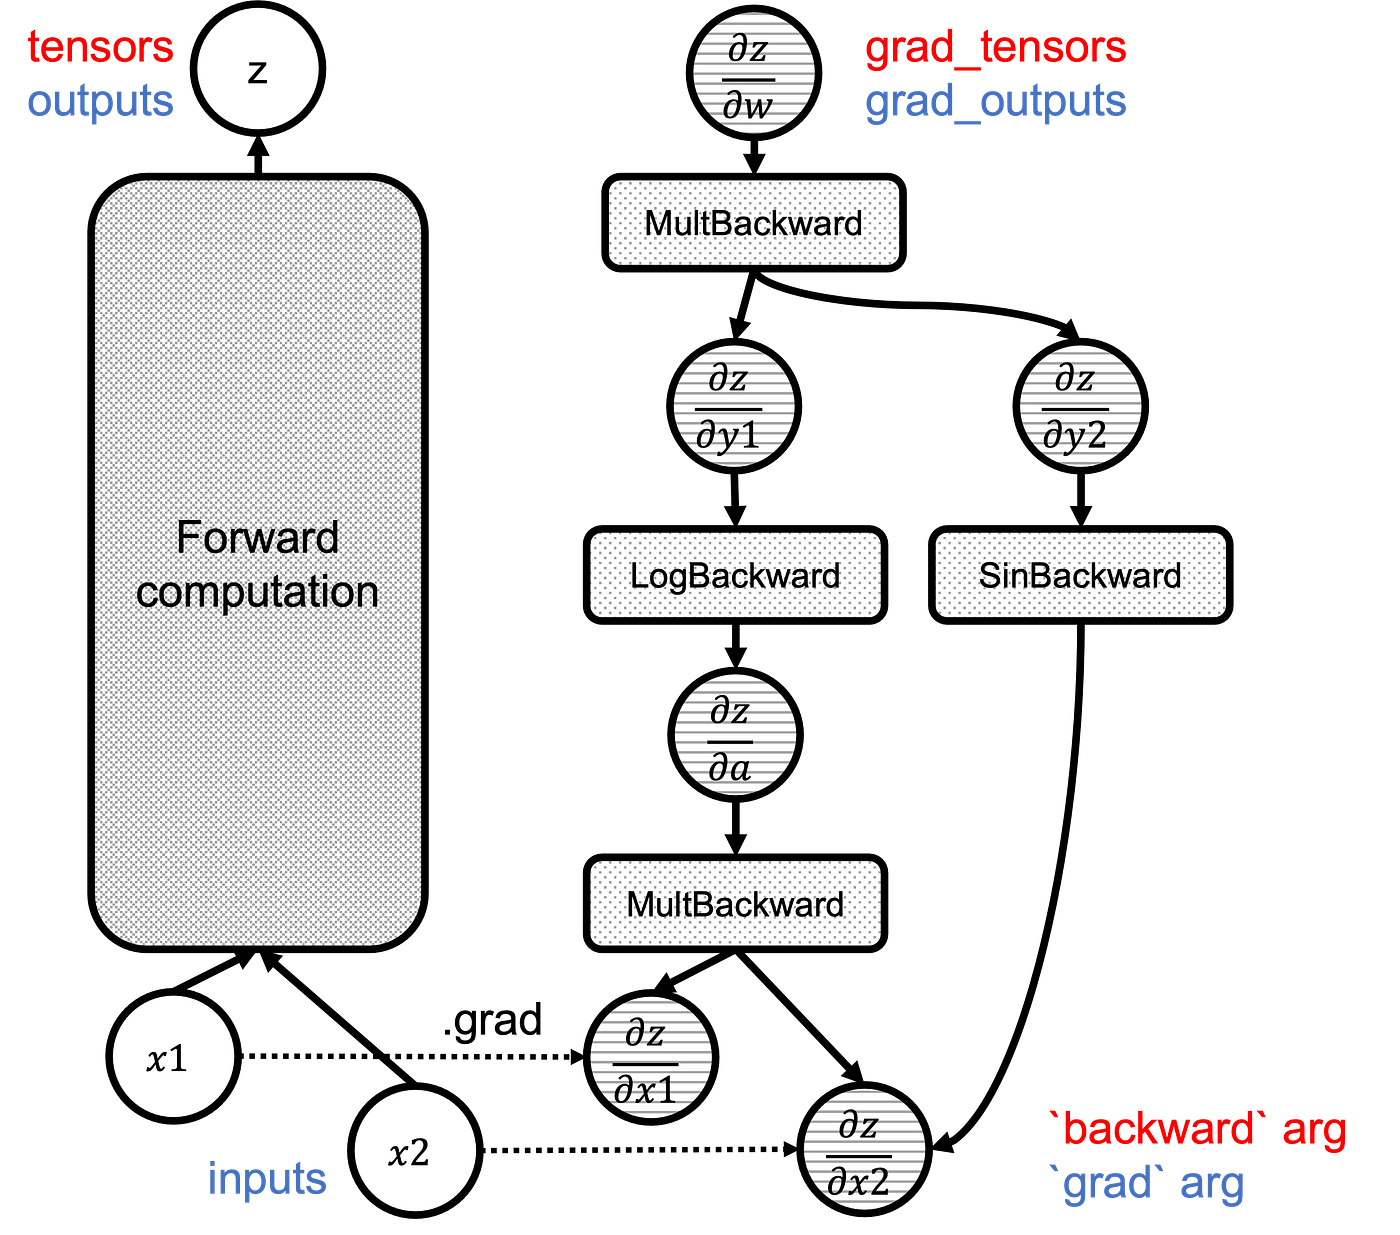

### 🔧 Why it matters for Transformers:

### 💡 Key Insight:

**Every parameter in a Transformer is a tensor:**

- Embedding matrices: `(vocab_size, d_model)` — e.g., (50,000 × 512)

Without autograd, you'd need to manually derive and code gradients for every single operation!

- Query/Key/Value weights: `(d_model, d_model)` for each head```

    d_model is the primary dimension size that flows through the entire Transformer architecture. It's the embedding dimension — the size of the vector representation for each token at every layer.

    * d_model = 512  # Original Transformer paper
    * d_model = 768  # BERT-base
    * d_model = 256  # Our educational examples   


    ##### 📊 Common Values in Practice

    | Model | d_model | Parameters |
    |-------|---------|------------|
    | **Transformer (base)** | 512 | 65M |
    | **Transformer (big)** | 1024 | 213M |
    | **BERT-base** | 768 | 110M |
    | **BERT-large** | 1024 | 340M |
    | **GPT-2** | 768 | 117M |
    | **GPT-3** | 12,288 | 175B |
    | **LLaMA-7B** | 4096 | 7B |

    **Rule of thumb:** Larger d_model = more expressive representations, but more computation and memory!

    **Why d_model matters:**
    - **Information capacity**: Higher dimensions can encode more complex relationships
    - **Computational cost**: Scales quadratically in attention ($O(L^2 \times d_{model})$)
    - **Memory footprint**: Embedding tables grow linearly (vocab_size × d_model)




- Feed-forward layers: Two weight matrices of shapes `(d_model, d_ff)` and `(d_ff, d_model)`

        θ_new = θ_old - learning_rate × gradient

- Layer norm parameters: Learnable scale ($\gamma$) and shift ($\beta$) vectors```

**Practical example:** When you update weights with `optimizer.step()`, it uses gradients from autograd:

**Autograd handles the complexity:**

- Attention mechanism has nested matrix multiplications and softmax — computing gradients manually would be nightmare!- PyTorch computes all partial derivatives automatically using reverse-mode differentiation

- In a 6-layer Transformer with 8 attention heads, backpropagation goes through 100+ operations- Example gradient path: `loss → softmax → matmul → Q weights → embedding → input`

In [46]:
vector = torch.tensor([0.2, -0.4, 0.6], requires_grad=True)
weight = torch.randn(3, requires_grad=True)
loss = (vector * weight).sum()
loss.backward()
print("Loss:", loss.item())
print("Gradient on vector:", vector.grad)
print("Gradient on weight:", weight.grad)

Loss: 0.1564917266368866
Gradient on vector: tensor([0.3367, 0.1288, 0.2345])
Gradient on weight: tensor([ 0.2000, -0.4000,  0.6000])


### Sample Deep Neural Network (DNN) Code 


In [ ]:
# ============================================================================
# DEEP NEURAL NETWORK (DNN) TRAINING EXAMPLE: MULTI-CLASS CLASSIFICATION
# ============================================================================
# This example demonstrates a complete deep learning workflow with a DEEP network.
# We're building a 4-layer DNN to classify synthetic data into 5 categories.
#
# Key DNN Concepts Demonstrated:
# - Multiple hidden layers (depth = "deep" in deep learning!)
# - Dropout for regularization (prevents overfitting)
# - Batch normalization for training stability
# - Adam optimizer (better than SGD for deep networks)
# - CrossEntropyLoss for multi-class classification
# - Training/validation split
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ============================================================================
# STEP 1: DEFINE A DEEP NEURAL NETWORK ARCHITECTURE
# ============================================================================
class DeepNN(nn.Module):
    """
    A 4-layer Deep Neural Network for multi-class classification.
    
    Architecture:
        Input(20) → Dense(128) → BatchNorm → ReLU → Dropout(0.3) →
        Dense(64) → BatchNorm → ReLU → Dropout(0.3) →
        Dense(32) → BatchNorm → ReLU → Dropout(0.2) →
        Dense(5) [output logits]
    
    This is a DEEP network (4 layers) vs shallow (1-2 layers).
    Similar to Transformer blocks stacking, depth allows learning
    hierarchical features: early layers learn simple patterns,
    deeper layers learn complex combinations.
    """
    def __init__(self, input_size=20, hidden1=128, hidden2=64, hidden3=32, num_classes=5):
        super(DeepNN, self).__init__()
        
        # -------------------------
        # LAYER 1: Input → First Hidden Layer
        # -------------------------
        # Transform from input space (20 features) to first hidden space (128 neurons)
        # Parameters: 20×128 + 128 = 2,688 parameters
        self.fc1 = nn.Linear(input_size, hidden1)
        # BatchNorm: Normalizes activations (like LayerNorm but across batch)
        # Helps with training stability, especially in deep networks
        # Parameters: 128×2 (γ and β) = 256 learnable params
        
        # 🎯 Activations - neurons/layers outputs as data flows through a neural network. 
        # They're called "activations" because they represent which neurons are "activated" 
        # (producing non-zero values) for a given input
        # Activation functions introduce non-linearity.
        
        self.bn1 = nn.BatchNorm1d(hidden1)
        # Dropout: Randomly zeros 30% of neurons during training
        # Prevents overfitting by forcing network to learn redundant representations
        # No learnable parameters, just a regularization technique
        self.dropout1 = nn.Dropout(0.3)
        
        # -------------------------
        # LAYER 2: First Hidden → Second Hidden Layer
        # -------------------------
        # Compress from 128 → 64 neurons
        # Parameters: 128×64 + 64 = 8,256 parameters
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.dropout2 = nn.Dropout(0.3)
        
        # -------------------------
        # LAYER 3: Second Hidden → Third Hidden Layer
        # -------------------------
        # Further compress from 64 → 32 neurons
        # Parameters: 64×32 + 32 = 2,080 parameters
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.bn3 = nn.BatchNorm1d(hidden3)
        self.dropout3 = nn.Dropout(0.2)  # Less dropout in deeper layers
        
        # -------------------------
        # LAYER 4: Output Layer
        # -------------------------
        # Final projection to class logits (32 → 5 classes)
        # Parameters: 32×5 + 5 = 165 parameters
        # Output: raw scores (logits), not probabilities
        # CrossEntropyLoss will apply softmax internally
        self.fc4 = nn.Linear(hidden3, num_classes)
        
        # Total parameters: 2,688 + 256 + 8,256 + 128 + 2,080 + 64 + 165 = 13,637
        
    def forward(self, x):
        """
        Forward pass through the deep network.
        
        Args:
            x: Input tensor of shape (batch_size, 20)
        
        Returns:
            Logits of shape (batch_size, 5) - raw class scores
        
        Key pattern in each block:
            Linear → BatchNorm → ReLU → Dropout
            
        This is similar to Transformer blocks:
            Attention → LayerNorm → FFN → Dropout
        """
        # Block 1: (batch, 20) → (batch, 128)
        x = self.fc1(x)           # Linear transformation
        x = self.bn1(x)           # Normalize (stabilizes training)
        x = torch.relu(x)         # Non-linearity (allows learning complex functions)
        x = self.dropout1(x)      # Regularization (prevents overfitting)
        
        # Block 2: (batch, 128) → (batch, 64)
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        
        # Block 3: (batch, 64) → (batch, 32)
        x = self.fc3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.dropout3(x)
        
        # Block 4: (batch, 32) → (batch, 5) [output layer, no activation]
        # No ReLU/BatchNorm/Dropout here - raw logits for CrossEntropyLoss
        x = self.fc4(x)
        
        return x  # Shape: (batch, 5) - logits for 5 classes

# ============================================================================
# STEP 2: GENERATE SYNTHETIC TRAINING DATA
# ============================================================================
# In real projects, you'd load data from files (CSV, images, etc.)
# Here we create synthetic data for demonstration

torch.manual_seed(42)  # For reproducibility

# Generate random features and labels
n_samples = 1000       # Total number of training examples
input_dim = 20         # Number of input features per example
n_classes = 5          # Number of categories to classify into

# Create random input data: 1000 examples × 20 features
# Values drawn from standard normal distribution N(0, 1)
X = torch.randn(n_samples, input_dim)

# Create random class labels: integers from 0 to 4
# Each example belongs to one of 5 classes
y = torch.randint(0, n_classes, (n_samples,))

# Split into training (800) and validation (200) sets
# CRITICAL: Always evaluate on data the model hasn't seen during training!
train_size = 800
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Input features: {input_dim}, Output classes: {n_classes}")

# Create DataLoader for batching
# Instead of processing all 800 examples at once, we process in batches of 32
# This is more memory-efficient and often leads to better generalization
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ============================================================================
# STEP 3: INSTANTIATE MODEL, LOSS, AND OPTIMIZER
# ============================================================================
model = DeepNN(input_size=input_dim, num_classes=n_classes)

# Count parameters (useful for understanding model complexity)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# CrossEntropyLoss for multi-class classification
# Combines nn.LogSoftmax + nn.NLLLoss in one class
# Formula: L = -log(softmax(logits)[correct_class])
# Expects: predictions as logits (raw scores), targets as class indices (0-4)
criterion = nn.CrossEntropyLoss()

# Adam optimizer - adaptive learning rate, works better than SGD for deep networks
# Combines momentum + RMSProp for faster, more stable convergence
# lr=0.001 is a standard starting point (much higher than SGD's 0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ============================================================================
# STEP 4: TRAINING LOOP WITH VALIDATION
# ============================================================================
num_epochs = 50  # Fewer epochs needed with Adam and good architecture

print(f"\n{'='*60}")
print("Starting training...")
print(f"{'='*60}")

for epoch in range(num_epochs):
    # -------------------------
    # 4a. TRAINING PHASE
    # -------------------------
    model.train()  # Enable dropout and batch norm training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Iterate through mini-batches
    for batch_X, batch_y in train_loader:
        # batch_X: (32, 20), batch_y: (32,)
        
        # Forward pass
        outputs = model(batch_X)  # (32, 5) - logits for 5 classes
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients via backprop
        optimizer.step()       # Update weights
        
        # Track metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, dim=1)  # Get predicted class (argmax)
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()
    
    # Average loss and accuracy over all batches
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    
    # -------------------------
    # 4b. VALIDATION PHASE
    # -------------------------
    model.eval()  # Disable dropout, use running stats for batch norm
    with torch.no_grad():  # No gradient computation needed for validation
        val_outputs = model(X_val)  # (200, 5)
        val_loss = criterion(val_outputs, y_val)
        _, val_predicted = torch.max(val_outputs, dim=1)
        val_accuracy = 100 * (val_predicted == y_val).sum().item() / y_val.size(0)
    
    # -------------------------
    # 4c. LOGGING
    # -------------------------
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

print(f"{'='*60}")
print("✓ Training complete!")
print(f"{'='*60}")

# ============================================================================
# STEP 5: FINAL EVALUATION
# ============================================================================
model.eval()
with torch.no_grad():
    # Get predictions on validation set
    final_outputs = model(X_val)
    final_predictions = torch.argmax(final_outputs, dim=1)
    final_accuracy = 100 * (final_predictions == y_val).sum().item() / len(y_val)
    
    print(f"\n📊 Final Validation Results:")
    print(f"   Accuracy: {final_accuracy:.2f}%")
    print(f"   Correct: {(final_predictions == y_val).sum().item()}/{len(y_val)}")
    
    # Show some example predictions
    print(f"\n   Sample predictions (first 10):")
    for i in range(10):
        pred = final_predictions[i].item()
        actual = y_val[i].item()
        status = "✓" if pred == actual else "✗"
        print(f"     {status} Predicted: {pred}, Actual: {actual}")

print(f"\n{'='*60}")
print("🎯 Key takeaways:")
print("  • DNNs have multiple hidden layers (depth)")
print("  • BatchNorm + Dropout prevent overfitting")
print("  • Adam optimizer adapts learning rates automatically")
print("  • Always validate on unseen data!")
print(f"{'='*60}")


Training set: 800 samples
Validation set: 200 samples
Input features: 20, Output classes: 5

Model architecture:
  Total parameters: 13,637
  Trainable parameters: 13,637

Starting training...
Epoch [10/50] | Train Loss: 1.5540 | Train Acc: 29.25% | Val Loss: 1.6557 | Val Acc: 21.00%
Epoch [20/50] | Train Loss: 1.4604 | Train Acc: 37.50% | Val Loss: 1.7049 | Val Acc: 15.00%
Epoch [30/50] | Train Loss: 1.4163 | Train Acc: 39.00% | Val Loss: 1.7456 | Val Acc: 16.50%
Epoch [40/50] | Train Loss: 1.3383 | Train Acc: 45.50% | Val Loss: 1.8149 | Val Acc: 16.00%
Epoch [50/50] | Train Loss: 1.2822 | Train Acc: 48.12% | Val Loss: 1.8471 | Val Acc: 16.50%
✓ Training complete!

📊 Final Validation Results:
   Accuracy: 16.50%
   Correct: 33/200

   Sample predictions (first 10):
     ✓ Predicted: 1, Actual: 1
     ✗ Predicted: 2, Actual: 4
     ✗ Predicted: 1, Actual: 3
     ✗ Predicted: 4, Actual: 0
     ✗ Predicted: 0, Actual: 2
     ✗ Predicted: 3, Actual: 4
     ✗ Predicted: 3, Actual: 1
     ✗

## 2. `nn.Module` & Learnable Parameters

### 🎯 What it does:

**`nn.Module`** is the base class for all neural network layers and models in PyTorch:
- **Inheritance**: Every custom layer/model inherits from `nn.Module`
- **`__init__()`**: Define your parameters and sub-modules here
- **`forward()`**: Define the computation performed at every call
- **Automatic registration**: Sub-modules and parameters are automatically tracked

**`nn.Parameter`** wraps tensors that should be optimized:
- **Learnable tensors**: `nn.Parameter(torch.randn(10, 5))` creates a trainable weight matrix
- **Auto-registration**: Parameters defined in `__init__` are automatically registered
- **Gradient tracking**: Equivalent to a tensor with `requires_grad=True`, but with module integration

`nn.Module` is like a "smart container" that makes neural networks composable. You can nest modules infinitely deep, and PyTorch automatically handles all the bookkeeping. This is why you can build a 6-layer Transformer with hundreds of weight matrices and move it all to GPU with one line: `model.to('cuda')`!

### 💡 Key Insight:

`nn.Module` is like a "smart container" that makes neural networks composable. You can nest modules infinitely deep, and PyTorch automatically handles all the bookkeeping. This is why you can build a 6-layer Transformer with hundreds of weight matrices and move it all to GPU with one line: `model.to('cuda')`!

**Automatic features:**

- **`.parameters()`**: Returns an iterator over all learnable parameters
- **`.named_parameters()`**: Returns name-value pairs of parameters (useful for debugging)
- **`.to(device)`**: Moves all parameters and buffers to CPU/GPU/TPU
- **`.state_dict()`**: Returns a dictionary of all parameters (for saving)
- **`.load_state_dict()`**: Loads parameters from a dictionary (for loading)


### 🔧 Why it matters for Transformers:

Without `nn.Module`, you'd need to manually track and move every single weight tensor.

**Modular architecture design:**

Transformers are built from nested `nn.Module` components:

```
Transformer (nn.Module)
├── Encoder (nn.Module)
│   └── 6 × EncoderLayer (nn.Module)
│       ├── MultiHeadAttention (nn.Module)
│       │   ├── Q_linear (nn.Linear)
│       │   ├── K_linear (nn.Linear)
│       │   ├── V_linear (nn.Linear)
│       │   └── output_linear (nn.Linear)
│       └── FeedForward (nn.Module)
│           ├── linear1 (nn.Linear)
│           └── linear2 (nn.Linear)
└── Decoder (nn.Module)
    └── 6 × DecoderLayer (nn.Module)
        └── ... (similar structure)
```

**Optimizer integration example:**

```python
model = Transformer()
# optimizer.parameters() finds ALL parameters in the entire hierarchy!
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
```

#### 💻 Example code:

Minimal example showing automatic parameter registration and `nn.Module` mechanics:

In [ ]:
class SimpleScaler(nn.Module):
    """A minimal nn.Module that scales input by a learnable parameter."""
    
    def __init__(self):
        super().__init__()  # REQUIRED: Initialize parent nn.Module
        # nn.Parameter wraps a tensor and marks it as trainable
        # PyTorch automatically registers this in the module's parameter list
        self.scale = nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        """Forward pass: multiply input by learnable scale."""
        return x * self.scale

# ============= Testing the module =============
scaler = SimpleScaler()

# 1. Inspect registered parameters
print("Registered parameters:")
print(dict(scaler.named_parameters()))
# Output: {'scale': Parameter containing: tensor(1., requires_grad=True)}
# ✓ 'scale' is automatically registered - no manual tracking needed!

# 2. Test forward pass
input_tensor = torch.ones(3)  # [1.0, 1.0, 1.0]
output = scaler(input_tensor)  # Calls forward() automatically
print(f"\nInput: {input_tensor}")
print(f"Output: {output}")
# Output: [1.0, 1.0, 1.0] × 1.0 = [1.0, 1.0, 1.0]

# 3. Show gradient tracking
print(f"\nGradient tracking enabled: {scaler.scale.requires_grad}")
# Output: True - ready for optimization!

print("\n✓ Parameter automatically registered and accessible to optimizers!")

## 3. Token Embeddings with `nn.Embedding`

### 🎯 What it does:

**`nn.Embedding`** creates a learnable lookup table that converts discrete tokens into continuous vectors:

- **Initialization**: `nn.Embedding(vocab_size=50000, embedding_dim=512)`
- **Storage**: Internally stores a weight matrix of shape `(vocab_size, embedding_dim)`
- **Lookup**: `embedding(token_ids)` performs efficient indexing (not matrix multiplication!)
- **Backpropagation**: Only the embeddings corresponding to input tokens receive gradient updates

**How it works mathematically:**
- Given token ID $t \in \{0, 1, ..., V-1\}$ where $V$ is vocab size
- Embedding matrix $E \in \mathbb{R}^{V \times d_{model}}$
- Output: $\text{embedding}(t) = E[t, :]$ — the $t$-th row of $E$
- For a sequence: `[42, 17, 89]` → returns a `(3, d_model)` tensor

---

### 🔧 Why it matters for Transformers:

**The bridge from text to numbers:**

Text processing pipeline:
```
"Hello world"
  ↓ (tokenization)
[15496, 995]
  ↓ (embedding lookup)
[[0.23, -0.51, 0.18, ...],   # 512-dim vector for "Hello"
 [0.41, 0.02, -0.33, ...]]   # 512-dim vector for "world"
```

**Semantic meaning emerges from training:**

*Initially:* Random vectors with no meaning
```python
embedding("king") = [0.23, -0.11, 0.54, ...]
embedding("queen") = [-0.88, 0.23, -0.12, ...]
```

*After training on millions of sentences:*
```python
embedding("king") = [0.71, 0.33, -0.24, ...]
embedding("queen") = [0.69, 0.31, -0.21, ...]  # Very similar!
embedding("apple") = [-0.45, -0.82, 0.61, ...] # Very different
```

- Cosine similarity: `cos("king", "queen") ≈ 0.82` (close)
- Cosine similarity: `cos("king", "apple") ≈ 0.15` (distant)

---

**Scaling factor $\sqrt{d_{model}}$:**

The original Transformer paper scales embeddings:
```python
embedded = embedding(tokens) * math.sqrt(d_model)
```

**Why?** Positional encodings use sine/cosine with values in $[-1, 1]$. Without scaling:
- Embeddings (initialized ~N(0, 1)) have similar magnitude to positional encodings
- After adding them, positional information might dominate or be dominated
- Scaling by $\sqrt{d_{model}}$ (e.g., $\sqrt{512} \approx 22.6$) ensures embeddings have larger magnitude

---

**Memory consideration:**

For GPT-3 scale (vocab_size=50,257, d_model=12,288):
- Embedding matrix: 50,257 × 12,288 = ~618M parameters
- At float32: 618M × 4 bytes = **2.4 GB just for embeddings!**

---

### 💡 Key Insight:

**Embeddings are where language becomes geometry!** Words that appear in similar contexts ("cat" near "dog", "king" near "queen") end up with similar vectors. This geometric structure is what enables Transformers to understand semantic relationships. The model never sees the actual text — only these learned vector representations!

In [48]:
embedding = nn.Embedding(num_embeddings=20, embedding_dim=8)
token_ids = torch.tensor([[2, 5, 7]])
embedded = embedding(token_ids) * math.sqrt(8)
print("Embedding shape:", embedded.shape)
print("First token vector:", embedded[0, 0])

Embedding shape: torch.Size([1, 3, 8])
First token vector: tensor([ 1.0065, -1.9421, -1.3954,  0.6830, -3.1421,  0.2589, -6.5532, -0.6132],
       grad_fn=<SelectBackward0>)


## 4. Sinusoidal Positional Encoding

### 🎯 What it does:

**Positional Encoding** injects information about token position into the model using fixed (non-learned) trigonometric functions.

**The formulas:**
- For **even** dimensions (0, 2, 4, ...): $PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$
- For **odd** dimensions (1, 3, 5, ...): $PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$

**Where:**
- $pos$ = position in sequence (0, 1, 2, ..., seq\_len-1)
- $i$ = dimension index (0, 1, 2, ..., $d_{model}/2 - 1$)
- $d_{model}$ = embedding dimension (e.g., 512)

**What this creates:**

Each position gets a unique "fingerprint" — a vector of sine/cosine values at different frequencies:
```
Position 0: [sin(0/10000^0), cos(0/10000^0), sin(0/10000^0.004), cos(0/10000^0.004), ...]
Position 1: [sin(1/10000^0), cos(1/10000^0), sin(1/10000^0.004), cos(1/10000^0.004), ...]
Position 2: [sin(2/10000^0), cos(2/10000^0), sin(2/10000^0.004), cos(2/10000^0.004), ...]
```

**Frequency decomposition:**
- **Low dimensions** (i=0, 1): High frequency → changes rapidly with position (fine-grained)
- **High dimensions** (i=255): Low frequency → changes slowly with position (coarse-grained)
- Wavelength ranges from $2\pi$ to $10000 \times 2\pi$

---

### 🔧 Why it matters for Transformers:

**The fundamental problem: Attention is permutation-invariant**

Without positional encoding, these sequences look **identical** to the model:
```
"The cat chased the mouse"     [The, cat, chased, the, mouse]
"The mouse chased the cat"     [The, mouse, chased, the, cat]
"Chased the mouse the cat"     [Chased, the, mouse, the, cat]
```

**Why?** Self-attention computes:
```
Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) V
```
Matrix multiplication is permutation-invariant! The attention weights depend only on content, not order.

**The solution: Add position information to embeddings**
```python
token_embedding = embedding_layer(token_ids)  # (batch, seq_len, d_model)
positional_encoding = sinusoidal_pe(seq_len)  # (seq_len, d_model)
final_input = token_embedding + positional_encoding
```

Now "cat" at position 0 has a different representation than "cat" at position 4!

---

**Why sinusoidal functions?**

1. **Unique patterns**: No two positions have the same encoding
2. **Smooth**: Nearby positions have similar encodings (position 5 ≈ position 6)
3. **Extrapolation**: Can handle sequences longer than seen during training!
   - Trained on sequences up to length 512? Can still encode position 1000!
   - Linear combinations: $PE(pos + k)$ can be expressed as linear function of $PE(pos)$
4. **No learned parameters**: Reduces model complexity (though learned PE also works)

**Comparison with learned positional embeddings:**

| Aspect | Sinusoidal | Learned |
|--------|-----------|----------|
| Parameters | 0 | seq_len × d_model |
| Extrapolation | Yes | No (only up to trained length) |
| Performance | Slightly worse | Slightly better |
| Used in | Original Transformer | BERT, GPT |

---

### 💡 Key Insight:

Positional encoding is the reason Transformers can understand word order! The genius is using sine/cosine waves at different frequencies — it's like giving each position a unique barcode. Low-frequency components capture "this token is in the first half" while high-frequency components capture "this token is exactly at position 47".

In [49]:
def sinusoidal_positional_encoding(seq_len, d_model):
    position = torch.arange(seq_len, dtype=torch.float32).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(seq_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

pe = sinusoidal_positional_encoding(6, 16)
print("Positional encoding shape:", pe.shape)
print(pe[:2])

Positional encoding shape: torch.Size([6, 16])
tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00],
        [8.4147e-01, 5.4030e-01, 3.1098e-01, 9.5042e-01, 9.9833e-02, 9.9500e-01,
         3.1618e-02, 9.9950e-01, 9.9998e-03, 9.9995e-01, 3.1623e-03, 9.9999e-01,
         1.0000e-03, 1.0000e+00, 3.1623e-04, 1.0000e+00]])


## 5. `register_buffer` for Non-Trainable State

### 🎯 What it does:

**`register_buffer(name, tensor)`** stores a tensor as part of your module, but unlike `nn.Parameter`, it's not trainable.

**Key characteristics:**
- **Part of state_dict**: Saved when you call `torch.save(model.state_dict(), 'model.pt')`
- **Moves with model**: Automatically transferred when you call `model.to('cuda')`
- **No gradients**: PyTorch won't compute gradients for buffers
- **Not in parameters()**: Excluded from `model.parameters()` (optimizer ignores them)
- **Access**: Use `model.named_buffers()` to list all buffers

**Syntax:**
```python
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        # Register a buffer (non-trainable)
        self.register_buffer('my_buffer', torch.randn(10, 10))
        # Register a parameter (trainable)
        self.my_param = nn.Parameter(torch.randn(10, 10))
```

**When to use buffers vs parameters:**

| Use Case | Use |
|----------|-----|
| Learned weights | `nn.Parameter` |
| Positional encodings | `register_buffer` |
| Causal attention mask | `register_buffer` |
| Running statistics (BatchNorm) | `register_buffer` |
| Any constant that needs to move with model | `register_buffer` |

---

### 🔧 Why it matters for Transformers:

**Problem 1: Positional encodings are computed once, not learned**

❌ **Bad approach** (values lost on device transfer):
```python
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        self.pe = self._compute_pe(max_len, d_model)  # Just a regular tensor!
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]  # ❌ Breaks when model.to('cuda')!
```

✅ **Good approach** (using register_buffer):
```python
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        pe = self._compute_pe(max_len, d_model)
        self.register_buffer('pe', pe)  # ✓ Moves automatically with model!
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]  # ✓ Works on CPU and GPU!
```

**Real-world scenario:**
```python
model = Transformer().to('cpu')
# ... train on CPU ...
model = model.to('cuda')  # Move to GPU

# Without register_buffer: positional encodings still on CPU → crash!
# With register_buffer: positional encodings automatically moved to GPU ✓
```

---

**Problem 2: Causal mask example**

In decoder layers, you need a lower-triangular mask:
```python
class Decoder(nn.Module):
    def __init__(self, max_len=512):
        super().__init__()
        # Create causal mask once during initialization
        causal_mask = torch.tril(torch.ones(max_len, max_len))
        self.register_buffer('causal_mask', causal_mask)
    
    def forward(self, x):
        # Mask is already on the right device!
        scores = scores.masked_fill(self.causal_mask[:L, :L] == 0, -1e9)
```

---

**Memory & checkpointing:**

For a model with max_len=2048, d_model=512:
- Positional encoding buffer: 2048 × 512 × 4 bytes = ~4MB
- Causal mask buffer: 2048 × 2048 × 4 bytes = ~16MB
- These are saved in `state_dict()` but excluded from optimizer state

---

### 💡 Key Insight:

`register_buffer` is for "constants that move" — values that are part of your model's configuration but shouldn't be trained. Think of it as saying: "PyTorch, please babysit this tensor for me. Move it when I move the model, save it when I save the model, but don't waste GPU memory computing gradients for it!"

In [50]:
class PositionalEncodingModule(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)  # Not a parameter!
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

pos_enc = PositionalEncodingModule(8)
print("Parameters:", list(pos_enc.parameters()))  # Empty!
print("Buffers:", dict(pos_enc.named_buffers()).keys())
print("PE shape:", pos_enc.pe.shape)

Parameters: []
Buffers: dict_keys(['pe'])
PE shape: torch.Size([1, 100, 8])


## 6. Tensor Shape Operations

### 🎯 What they do:

**`view()` and `reshape()`** — Change tensor shape without copying data:
```python
x = torch.randn(2, 3, 4)  # 24 elements
y = x.view(2, 12)          # Still 24 elements, different shape
z = x.view(-1)             # Flatten to 1D: (24,)
w = x.view(2, -1)          # Auto-calculate: (2, 12)
```
- **`view()`**: Requires contiguous memory, returns a view (shares storage)
- **`reshape()`**: May copy data if needed, always works
- **Rule**: Total number of elements must stay the same!

**`transpose(dim1, dim2)`** — Swap two dimensions:
```python
x = torch.randn(2, 3, 4)        # (batch, seq, features)
y = x.transpose(0, 1)           # (seq, batch, features)
z = x.transpose(1, 2)           # (batch, features, seq)
# Also: x.transpose(-2, -1) swaps last two dimensions (common for matmul)
```
- Creates a view (doesn't copy data)
- Often makes tensor non-contiguous
- Need `.contiguous()` before calling `.view()`

**`unsqueeze(dim)`** — Insert a dimension of size 1:
```python
x = torch.randn(3, 4)           # (3, 4)
y = x.unsqueeze(0)              # (1, 3, 4)
z = x.unsqueeze(1)              # (3, 1, 4)
w = x.unsqueeze(-1)             # (3, 4, 1)
```
- Essential for broadcasting
- Negative indices count from the end

**`squeeze()`** — Remove dimensions of size 1:
```python
x = torch.randn(1, 3, 1, 4)     # (1, 3, 1, 4)
y = x.squeeze()                  # (3, 4) - removes all size-1 dims
z = x.squeeze(0)                 # (3, 1, 4) - removes only dim 0
```

**`contiguous()`** — Ensure contiguous memory layout:
```python
x = torch.randn(3, 4)
y = x.transpose(0, 1)            # Non-contiguous!
z = y.view(12)                   # ❌ Error: view needs contiguous
z = y.contiguous().view(12)      # ✓ Works!
```

---

### 🔧 Why they matter for Transformers:

**Multi-head attention requires extensive shape manipulation:**

Let's trace through the shapes step-by-step for 8-head attention:

```python
# Input
x = torch.randn(32, 10, 512)  # (batch=32, seq_len=10, d_model=512)

# Step 1: Linear projection to Q, K, V
Q = self.q_linear(x)          # (32, 10, 512)
K = self.k_linear(x)          # (32, 10, 512)
V = self.v_linear(x)          # (32, 10, 512)

# Step 2: Split d_model into (num_heads, d_k)
# We want: (batch, num_heads, seq_len, d_k)
num_heads, d_k = 8, 64
Q = Q.view(32, 10, 8, 64)     # Split 512 into 8 heads of 64 dims each

# Step 3: Transpose to put heads before sequence
Q = Q.transpose(1, 2)          # (32, 8, 10, 64)
# Now: batch=32, heads=8, seq_len=10, d_k=64

# Step 4: Compute attention (same for K, V)
scores = Q @ K.transpose(-2, -1)  # (32, 8, 10, 10)
# Each head independently computes 10x10 attention matrix

weights = F.softmax(scores / math.sqrt(64), dim=-1)
out = weights @ V              # (32, 8, 10, 64)

# Step 5: Concatenate heads back together
out = out.transpose(1, 2)      # (32, 10, 8, 64)
out = out.contiguous()         # Make memory contiguous
out = out.view(32, 10, 512)    # Merge heads: 8*64 = 512
```

**Why each operation matters:**

1. **`.view(batch, seq_len, num_heads, d_k)`**: Splits d_model into separate heads
   - Enables parallel processing: 8 heads process 64 dims independently
   - Without split: single 512-dim attention → less expressive!

2. **`.transpose(1, 2)`**: Moves heads dimension before sequence
   - Allows matrix multiplication to work per-head
   - Shape becomes: `(batch, heads, seq, d_k)`
   - Now matmul operates on last two dims: `(seq, d_k) @ (d_k, seq)`

3. **`.contiguous()`**: Required after transpose before view
   - Why? `transpose` doesn't move data, just changes stride info
   - `view` requires contiguous memory layout
   - Without it: RuntimeError!

4. **`.unsqueeze()` for broadcasting masks:**
   ```python
   # Padding mask shape: (batch, seq_len) = (32, 10)
   mask = mask.unsqueeze(1).unsqueeze(2)  # (32, 1, 1, 10)
   # Broadcasts to (32, 8, 10, 10) when added to scores!
   ```

**Common mistake:**
```python
# ❌ Wrong
out = x.transpose(1, 2).view(batch, -1, d_model)  # Error!

# ✓ Correct
out = x.transpose(1, 2).contiguous().view(batch, -1, d_model)
```

---

These shape operations are the "plumbing" of Transformers. They don't do computation — they just rearrange how data is laid out in memory. The pattern `view → transpose → compute → transpose → contiguous → view` appears everywhere in multi-head attention. Master this, and you'll understand 80% of Transformer implementation!



In [51]:
x = torch.randn(2, 6, 16)  # (batch, seq_len, d_model)
print("Original:", x.shape)

# Split d_model into (num_heads, d_k)
num_heads, d_k = 4, 4
x_split = x.view(2, 6, num_heads, d_k)
print("After view:", x_split.shape)

# Transpose to (batch, num_heads, seq_len, d_k)
x_heads = x_split.transpose(1, 2)
print("After transpose:", x_heads.shape)

# Combine heads back
x_combined = x_heads.transpose(1, 2).contiguous().view(2, 6, 16)
print("Recombined:", x_combined.shape)

# unsqueeze adds dimensions for broadcasting
mask = torch.ones(6)
print("\nMask:", mask.shape)

mask_4d = mask.unsqueeze(0).unsqueeze(1).unsqueeze(2)
print("Mask 4D:", mask_4d.shape)  # (1, 1, 1, 6) for broadcasting

Original: torch.Size([2, 6, 16])
After view: torch.Size([2, 6, 4, 4])
After transpose: torch.Size([2, 4, 6, 4])
Recombined: torch.Size([2, 6, 16])

Mask: torch.Size([6])
Mask 4D: torch.Size([1, 1, 1, 6])


## 7. Scaled Dot-Product Attention Building Blocks

### 🎯 What they do:

The four fundamental operations of attention:

1. **`torch.matmul(Q, K.T)`**: Matrix multiplication to compute attention scores
2. **`/ math.sqrt(d_k)`**: Scale scores to prevent softmax saturation
3. **`F.softmax(scores, dim=-1)`**: Convert scores to probabilities (sum to 1)
4. **`torch.matmul(weights, V)`**: Weighted sum of values

**The complete formula:**
$$\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

---

### 🔧 Why they matter for Transformers:

**Step-by-step breakdown:**

**Step 1: Compute similarity scores**
```python
scores = torch.matmul(Q, K.transpose(-2, -1))  # Shape: (batch, heads, seq, seq)
```
- Each element `scores[i,j]` = similarity between query i and key j
- Higher score = more relevant
- Dot product measures how aligned two vectors are

**Step 2: Scale to prevent saturation**
```python
scores = scores / math.sqrt(d_k)
```
- **Why needed?** Dot products grow with dimension: $\mathbb{E}[q \cdot k] \propto d_k$
- Without scaling: For d_k=64, scores can be ±50, making softmax output nearly 0 or 1
- With scaling: Scores stay in reasonable range, gradients flow properly

**Step 3: Convert to probabilities**
```python
weights = F.softmax(scores, dim=-1)  # Each row sums to 1.0
```
- Converts scores to valid probability distribution
- Softmax: $\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$
- Each query decides how much to attend to each key

**Step 4: Weighted combination of values**
```python
output = torch.matmul(weights, V)  # Shape: (batch, heads, seq, d_k)
```
- Each position gets information from all other positions
- Weighted by attention probabilities
- High attention = more influence from that position

---

**Concrete example:**

Query: "What did the cat eat?"

Keys:  ["The", "cat", "ate", "fish"]

Attention weights for "What":
[0.05, 0.15, 0.30, 0.50]  # Attends most to "fish"!

Output for "What" = 0.05*V["The"] + 0.15*V["cat"] + 0.30*V["ate"] + 0.50*V["fish"]

---

### 💡 Key Insight:

Without the $\frac{1}{\sqrt{d_k}}$ scaling, dot products grow large as dimensions increase, pushing softmax into saturation where gradients approach zero. It's like turning a dimmer switch all the way to 0 or 100 — you lose the ability to make fine adjustments! This **IS** the core attention mechanism — everything else is just preprocessing!

In [52]:
def scaled_dot_product_attention(q, k, v):
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size(-1))
    weights = F.softmax(scores, dim=-1)
    return torch.matmul(weights, v), weights

batch, heads, seq_len, d_k = 1, 2, 4, 8
q = torch.randn(batch, heads, seq_len, d_k)
k = torch.randn(batch, heads, seq_len, d_k)
v = torch.randn(batch, heads, seq_len, d_k)

output, weights = scaled_dot_product_attention(q, k, v)
print("Attention output shape:", output.shape)
print("Attention weights shape:", weights.shape)
print("\nAttention weights (head 0):\n", weights[0, 0])
print("\nEach row sums to 1.0:", weights[0, 0].sum(dim=-1))

Attention output shape: torch.Size([1, 2, 4, 8])
Attention weights shape: torch.Size([1, 2, 4, 4])

Attention weights (head 0):
 tensor([[0.1305, 0.5485, 0.2102, 0.1107],
        [0.0596, 0.5003, 0.1831, 0.2570],
        [0.4257, 0.0137, 0.1142, 0.4464],
        [0.2938, 0.6119, 0.0220, 0.0723]])

Each row sums to 1.0: tensor([1., 1., 1., 1.])


## 8. `masked_fill` for Attention Masking

### 🎯 What it does:

**`tensor.masked_fill(mask == 0, value)`** replaces elements where the mask condition is true:

```python
scores = torch.randn(4, 4)
mask = torch.tril(torch.ones(4, 4))  # Lower triangular
scores = scores.masked_fill(mask == 0, -1e9)  # Set upper triangle to -1e9
```

**Key mechanism:**

- Setting scores to `-1e9` (effectively $-\infty$) before softmax
- After softmax: $e^{-1e9} \approx 0$, so masked positions get zero attention
- The mask "blinds" certain positions from being attended to

---

### 🔧 Why it matters for Transformers:

**Two types of masks:**

**1. Padding mask** — Ignore `<PAD>` tokens:

```python
# Sequence: ["Hello", "world", "<PAD>", "<PAD>"]
# Mask:     [   1   ,    1   ,    0   ,    0   ]

# Without mask: Model wastes attention on meaningless padding
# With mask: Model only attends to real tokens
```

**Why needed?** Batching requires same-length sequences:

```
Sentence 1: "I love cats"           → length 3    
Sentence 2: "Hello"                 → length 1, pad to 3
Batch:      [["I", "love", "cats"],
             ["Hello", "<PAD>", "<PAD>"]]
```

Without padding mask, "Hello" would attend to meaningless `<PAD>` tokens!

**2. Causal mask** — Prevent seeing future tokens:

```python
# During training on "The cat sat"
# Position 0 ("The") can see: ["The"]
# Position 1 ("cat") can see: ["The", "cat"]
# Position 2 ("sat") can see: ["The", "cat", "sat"]

# Causal mask (lower triangular):
# [[1, 0, 0],
#  [1, 1, 0],
#  [1, 1, 1]]
```

**Why needed?** Training-inference consistency:

```
Training:   Full sequence known, but must mask future
Inference:  Only past tokens available
→ Must train with same constraints as inference!
```

---

**Implementation:**

```python
def attention_with_mask(q, k, v, mask=None):
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size(-1))
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)  # Before softmax!
    weights = F.softmax(scores, dim=-1)  # Now masked positions ≈ 0
    return torch.matmul(weights, v), weights
```

**Timing matters:**

✓ **Correct:**  scores → mask → softmax
```python
scores = scores.masked_fill(mask == 0, -1e9)
weights = F.softmax(scores, dim=-1)
```

✗ **Wrong:**    scores → softmax → mask
```python
weights = F.softmax(scores, dim=-1)
weights = weights.masked_fill(mask == 0, 0)
# Probabilities no longer sum to 1!
```

**Why the order matters:**

When you mask **before** softmax:
```
scores: [-2.1, 0.5, 3.2, -1e9, -1e9]
          ↓ softmax
weights: [0.01, 0.11, 0.88, ~0.0, ~0.0]  ✓ Sums to 1.0
```

When you mask **after** softmax (WRONG):
```
scores: [-2.1, 0.5, 3.2, 1.8, -0.3]
          ↓ softmax
weights: [0.02, 0.15, 0.45, 0.28, 0.10]  = 1.0
          ↓ mask positions 3 and 4
weights: [0.02, 0.15, 0.45, 0.00, 0.00]  = 0.62 ❌ No longer a valid probability!
```

---

### 💡 Key Insight:

Masking happens **before** softmax, not after! Setting scores to $-\infty$ ensures softmax outputs exactly zero for masked positions, and the remaining probabilities still sum to 1. It's the difference between "don't look there" (masking) and "ignore what you saw" (too late!).

In [68]:
# Demonstrating masked_fill for attention masking
def attention_with_mask(q, k, v, mask=None):
    """Attention with optional masking"""
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size(-1))
    
    if mask is not None:
        # masked_fill replaces values where mask == 0 with -1e9
        scores = scores.masked_fill(mask == 0, -1e9)
    
    weights = F.softmax(scores, dim=-1)
    return torch.matmul(weights, v), weights

# Example: masking out certain positions
batch, heads, seq_len, d_k = 1, 1, 4, 8
q = torch.randn(batch, heads, seq_len, d_k)
k = torch.randn(batch, heads, seq_len, d_k)
v = torch.randn(batch, heads, seq_len, d_k)

# Create a mask: allow attention to first 3 tokens only
mask = torch.tensor([[[[1, 1, 1, 0]]]])  # Shape: (1, 1, 1, 4)

# Without mask
output_no_mask, weights_no_mask = attention_with_mask(q, k, v, mask=None)
print("Attention weights WITHOUT mask:")
print(weights_no_mask[0, 0, 0])  # First query attends to all keys

# With mask
output_masked, weights_masked = attention_with_mask(q, k, v, mask=mask)
print("\nAttention weights WITH mask:")
print(weights_masked[0, 0, 0])  # Last position gets zero attention

print("\n✓ Position 3 (index 3) has zero attention weight due to masking")

Attention weights WITHOUT mask:
tensor([0.0817, 0.0688, 0.7553, 0.0942])

Attention weights WITH mask:
tensor([0.0902, 0.0759, 0.8338, 0.0000])

✓ Position 3 (index 3) has zero attention weight due to masking


## 9. Residual Connections & Layer Normalization

### 🎯 What they do:

**Residual Connection (Skip Connection):**
```python
def sublayer_with_residual(x, sublayer):
    return x + sublayer(x)
```
- **Identity shortcut**: Adds input directly to output of a layer
- **Formula**: $\text{output} = \mathcal{F}(x) + x$ where $\mathcal{F}$ is the sublayer (attention or FFN)
- **Gradient flow**: Creates direct path for gradients to flow backward

**Layer Normalization:**
```python
ln = nn.LayerNorm(d_model, eps=1e-5)
```
- **Normalizes** across the feature dimension (d_model), not batch dimension
- **Formula**: $\text{LayerNorm}(x) = \gamma \odot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$
  - $\mu = \frac{1}{d_{model}} \sum_{i=1}^{d_{model}} x_i$ (mean)
  - $\sigma^2 = \frac{1}{d_{model}} \sum_{i=1}^{d_{model}} (x_i - \mu)^2$ (variance)
  - $\gamma, \beta$ are learnable scale and shift parameters (initialized to 1 and 0)
  - $\epsilon$ prevents division by zero (typically 1e-5)

#### 📌 Understanding Gamma (γ) and Beta (β):

After LayerNorm normalizes your data to mean≈0 and std≈1, **gamma** and **beta** give the network flexibility to learn if it wants a different distribution:

**γ (gamma)** = **scale parameter** (learnable, starts at 1.0)
- Controls "how spread out should the values be?"
- Multiplies the normalized values: stretches or shrinks the distribution
- Shape: `(d_model,)` — one learnable value per feature dimension

**β (beta)** = **shift parameter** (learnable, starts at 0.0)
- Controls "what should the center point be?"
- Adds to the normalized values: moves the distribution up or down
- Shape: `(d_model,)` — one learnable value per feature dimension

**Breaking down the formula:**
1. **Normalize**: $\frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}$ → forces mean=0, std=1
2. **Scale**: $\gamma \odot (\ldots)$ → stretches/shrinks each feature independently
3. **Shift**: $+ \beta$ → moves each feature's center up or down

**Why do we need them?**

Without γ and β, LayerNorm would **always** force values to mean=0, std=1. But sometimes the network learns that other distributions work better!

**Concrete example:**
```python
# After normalization: mean=0, std=1
normalized = [-1.5, -0.5, 0.5, 1.5]

# Network learns during training: γ=2.0, β=3.0
output = γ * normalized + β
output = [0.0, 2.0, 4.0, 6.0]  # mean=3, std=2
```

The network learned "actually, I want mean=3 and std=2 for this feature, not 0 and 1!"

**In PyTorch:**
```python
ln = nn.LayerNorm(d_model=512)
# ln.weight is gamma (shape: [512]) — learnable via backprop
# ln.bias is beta (shape: [512]) — learnable via backprop
```

Each of the 512 features gets its own γ and β that update during training, just like any other weight!

**Think of it as a two-step process:**
1. **Standardize** (forced normalization to consistent scale)
2. **Customize** (γ and β let the network learn the optimal scale/shift)

---

**LayerNorm vs BatchNorm:**

| Aspect | LayerNorm | BatchNorm |
|--------|-----------|------------|
| Normalizes over | Features (d_model) | Batch dimension |
| Shape (batch, seq, d_model) | Across dim 2 | Across dim 0 |
| Depends on batch size | No | Yes |
| Used in | Transformers, RNNs | CNNs |
| Train/eval difference | None | Yes (running stats) |

---

### 🔧 Why it matters for Transformers:

**Problem 1: Vanishing Gradients in Deep Networks**

Without residual connections in a 6-layer network:
```
Layer 6 ← Layer 5 ← Layer 4 ← Layer 3 ← Layer 2 ← Layer 1 ← Input

Gradient: ∂L/∂L6 × ∂L6/∂L5 × ∂L5/∂L4 × ... × ∂L2/∂L1
```
If each derivative is < 1, the product becomes tiny: $0.8^6 \approx 0.26$

Early layers barely learn!

**With residual connections:**
```python
output = x + sublayer(x)
```
Gradient: $\frac{\partial \text{output}}{\partial x} = 1 + \frac{\partial \text{sublayer}(x)}{\partial x}$

The "$1$" ensures gradient always has a direct path! Even if sublayer gradient vanishes, the identity path remains.

**Transformer architecture with residuals:**
```python
# Encoder layer
class EncoderLayer(nn.Module):
    def forward(self, x):
        # Attention sublayer with residual
        x = x + self.attention(x)           # Residual connection
        x = self.norm1(x)                   # Layer norm
        
        # Feed-forward sublayer with residual  
        x = x + self.feed_forward(x)        # Residual connection
        x = self.norm2(x)                   # Layer norm
        return x
```

**Two architectural variants:**

**Post-LN (Original paper):**
```python
x = norm(x + sublayer(x))  # Add then normalize
```

**Pre-LN (Modern, more stable):**
```python
x = x + sublayer(norm(x))  # Normalize then add
```

Pre-LN is now preferred because:
- More stable training (especially for very deep models)
- Gradients flow more directly through residual stream
- Used in GPT-2, GPT-3, and most modern Transformers

---

**Problem 2: Internal Covariate Shift**

Without LayerNorm, activation distributions shift during training:
```
Epoch 1: mean=0.0, std=1.0
Epoch 10: mean=2.3, std=5.8   # Activations exploding!
Epoch 20: mean=15.2, std=45.1 # Even worse
```

With LayerNorm, activations stay normalized:
```
Epoch 1: mean≈0, std≈1
Epoch 10: mean≈0, std≈1  # Stable!
Epoch 20: mean≈0, std≈1
```

**Why LayerNorm works for sequences:**

BatchNorm problem with variable-length sequences:
```
Batch of sequences:
Seq 1: [tok1, tok2, tok3, PAD, PAD]  length=3
Seq 2: [tok1, tok2, PAD, PAD, PAD]   length=2

BatchNorm would compute statistics across batch at each position
→ Position 4 only has padding! Statistics are meaningless.
```

LayerNorm solution: Normalize each token independently across features
```
For each token: normalize its d_model features
→ Works regardless of sequence length or padding!
```

**Practical impact:**

Training a 6-layer Transformer:
- **Without residuals**: Gradients vanish, loss plateaus, model fails
- **With residuals but no LayerNorm**: Training is unstable, requires very careful learning rate tuning  
- **With both**: Smooth training, converges reliably

---

### 💡 Key Insight:

Residual connections + LayerNorm are the dynamic duo that enable deep Transformers! Residuals provide "gradient highways" so backprop reaches early layers. LayerNorm keeps activations in a healthy range so gradients don't explode or vanish. Together, they're why we can stack 6, 12, 24, or even 96 layers (GPT-3)!

In [69]:
# Demonstrating residual connections and layer normalization
layer_norm = nn.LayerNorm(16)
x = torch.randn(2, 4, 16)  # (batch, seq_len, d_model)

# Simulate a sublayer (e.g., attention or FFN)
sublayer_output = torch.randn_like(x) * 0.5

# Residual connection
residual = x + sublayer_output
print("Before LayerNorm - mean:", residual.mean().item(), "std:", residual.std().item())

# Apply layer normalization
normalized = layer_norm(residual)
print("After LayerNorm - mean:", normalized.mean().item(), "std:", normalized.std().item())

print("\nResidual connection shape:", residual.shape)
print("LayerNorm has learnable parameters:", list(layer_norm.parameters()))

Before LayerNorm - mean: 0.09700772166252136 std: 1.124060034751892
After LayerNorm - mean: -1.862645149230957e-08 std: 1.0039249658584595

Residual connection shape: torch.Size([2, 4, 16])
LayerNorm has learnable parameters: [Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)]


## 10. Feed-Forward Networks (FFN)

### 🎯 What it does:

**Position-wise Feed-Forward Network** is a two-layer MLP applied independently to each token:

**Architecture:**
```python
FFN(x) = max(0, xW_1 + b_1)W_2 + b_2
```

Or equivalently:
```python
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (batch, seq_len, d_model)
        x = self.linear1(x)        # (batch, seq_len, d_ff)
        x = F.relu(x)               # ReLU activation
        x = self.dropout(x)         # Dropout for regularization
        x = self.linear2(x)        # (batch, seq_len, d_model)
        return x
```

**Key parameters:**
- **d_model**: Input/output dimension (512 in base Transformer, 768 in BERT-base)
- **d_ff**: Hidden dimension (2048 in base Transformer, typically 4 × d_model)
- **Activation**: ReLU in original paper, but GELU increasingly popular (used in GPT, BERT)

**Activation functions compared:**

| Function | Formula | Properties |
|----------|---------|------------|
| ReLU | $\max(0, x)$ | Fast, simple, can cause "dying ReLU" |
| GELU | $x \cdot \Phi(x)$ | Smooth, stochastic (better gradients) |
| SwiGLU | $\text{Swish}(xW) \odot (xV)$ | State-of-art (used in LLaMA, PaLM) |

---

### 🔧 Why it matters for Transformers:

**Problem: Attention alone is just weighted averaging (linear!)**

Self-attention computes:
```
Attention(Q, K, V) = softmax(QK^T)V
```

This is just:
1. Compute similarity scores (dot products)
2. Normalize to probabilities (softmax)
3. Take weighted average of values

→ Entirely **linear** operations (except softmax, which is just normalization)!

Without non-linearity, stacking multiple attention layers gives no additional expressiveness:
```
Attention(Attention(x)) ≈ Attention(x)  # Still just weighted averaging!
```

**Solution: FFN adds non-linear transformations**

The ReLU activation introduces non-linearity:
```python
ReLU(x) = max(0, x)  # Non-linear!
```

This allows the network to learn complex, non-linear functions of the input.

---

**Why d_ff = 4 × d_model?**

The intermediate expansion serves multiple purposes:

1. **Increased capacity**: Projects into higher-dimensional space (512 → 2048)
   - More parameters → more expressiveness
   - Can learn more complex transformations

2. **Information bottleneck**: Then projects back down (2048 → 512)
   - Forces network to compress learned features
   - Acts as feature extraction/selection

3. **Parameter efficiency**: Despite expansion, FFN is parallelizable
   - All positions processed independently → massive parallelism
   - On GPU: `batch_size × seq_len` parallel FFN calls!

**Parameter count:**

For base Transformer (d_model=512, d_ff=2048):
```
Linear1: 512 × 2048 = 1,048,576 parameters
Linear2: 2048 × 512 = 1,048,576 parameters
Total per layer: ~2.1M parameters

In 6-layer encoder: 6 × 2.1M = ~12.6M just in FFN!
```

FFN contains **~2/3 of all Transformer parameters!**

**Computational cost:**

For sequence length L=512:
```
Attention: O(L² × d_model) = O(512² × 512) ≈ 134M ops
FFN: O(L × d_model × d_ff) = O(512 × 512 × 2048) ≈ 537M ops
```

FFN is 4× more expensive than attention for typical sequences!

(But attention becomes dominant for very long sequences due to $O(L^2)$)

---

**Position-wise independence:**

Crucial distinction from attention:

- **Attention**: Mixes information **across** sequence positions
  - Token at position 5 looks at tokens at all other positions
  - Shape: `(batch, seq_len, d_model)` → all positions interact

- **FFN**: Processes **each** position independently
  - Token at position 5 only transforms itself
  - Same weights applied to every position (like 1x1 convolution)
  - Shape: `(batch, seq_len, d_model)` → no cross-position interaction

**Intuitive roles:**

```
┌──────────────────────────┐
│  Encoder Layer               │
├──────────────────────────┤
│ Attention: "Look around"    │  ← Gather context from other tokens
│   (communication)            │
├──────────────────────────┤
│ FFN: "Think about it"        │  ← Process information locally
│   (computation)              │
└──────────────────────────┘
```

Analogy: FFN is like each person thinking independently after a group discussion (attention).

---

### 💡 Key Insight:

FFN is the "thinking" phase after attention's "communication" phase. Attention gathers information from across the sequence ("what should I pay attention to?"), then FFN processes that information locally ("what do I do with what I've gathered?"). The 4× expansion is like giving each token a bigger brain to process its context!

In [70]:
# Position-wise Feed-Forward Network
d_model = 16
d_ff = 64  # Typically 4x d_model

ffn = nn.Sequential(
    nn.Linear(d_model, d_ff),
    nn.ReLU(),
    nn.Linear(d_ff, d_model)
)

x = torch.randn(2, 4, d_model)  # (batch, seq_len, d_model)
output = ffn(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)
print("\nFFN parameters:")
for name, param in ffn.named_parameters():
    print(f"  {name}: {param.shape}")

Input shape: torch.Size([2, 4, 16])
Output shape: torch.Size([2, 4, 16])

FFN parameters:
  0.weight: torch.Size([64, 16])
  0.bias: torch.Size([64])
  2.weight: torch.Size([16, 64])
  2.bias: torch.Size([16])


## 11. `torch.tril` for Causal Masking

### 🎯 What it does:

**`torch.tril(tensor, diagonal=0)`** returns the lower triangular part of a matrix:

```python
torch.tril(torch.ones(4, 4))
```
Output:
```
tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])
```

**Parameters:**
- **`diagonal=0`** (default): Include main diagonal
- **`diagonal=1`**: Include diagonal above main
- **`diagonal=-1`**: Exclude main diagonal

**Related functions:**
- **`torch.triu()`**: Upper triangular (opposite of `tril`)
- **`torch.tril_indices()`**: Get indices of lower triangle

---

### 🔧 Why it matters for Transformers:

**The fundamental problem: Information leakage during training**

Consider training a language model on: `"The cat sat on the mat"`

**Without causal masking:**
```
Predicting "sat" at position 2:
  - Can see: "The", "cat", "sat", "on", "the", "mat"  ❌ CHEATING!
  - Model learns: "When I see 'sat', next word is 'on'"
```

**With causal masking:**
```
Predicting "sat" at position 2:
  - Can see: "The", "cat"  ✓ FAIR!
  - Model learns: "After 'The cat', next word is 'sat'"
```

---

**Training vs Inference mismatch:**

| Phase | Available context | Why masking matters |
|-------|------------------|---------------------|
| **Training** | Full sequence known | Must mask future to simulate inference |
| **Inference** | Only past tokens | Future tokens don't exist yet! |

Without masking: Model trains on full context but generates with partial context → poor performance!

---

**How causal masking works:**

**Step 1: Create lower-triangular mask**
```python
seq_len = 5
mask = torch.tril(torch.ones(seq_len, seq_len))
```

**Step 2: Apply before softmax in attention**
```python
scores = Q @ K.T / sqrt(d_k)  # Attention scores
scores = scores.masked_fill(mask == 0, -1e9)  # Mask future positions
weights = F.softmax(scores, dim=-1)  # Now future positions get ~0 weight
```

**Visual example with sequence length 5:**

Mask (1 = can attend, 0 = cannot attend):
```
           Key positions →
         0   1   2   3   4
       ┌───────────────┐
    0  │ 1   0   0   0   0 │  Query 0 can only see key 0
    1  │ 1   1   0   0   0 │  Query 1 can see keys 0-1
Q   2  │ 1   1   1   0   0 │  Query 2 can see keys 0-2
u   3  │ 1   1   1   1   0 │  Query 3 can see keys 0-3
e   4  │ 1   1   1   1   1 │  Query 4 can see keys 0-4
r       └───────────────┘
y
```

**Why -1e9 and not -inf?**

- **`-1e9`**: Large enough to make softmax output ≈0, but avoids NaN issues
- **`-float('inf')`**: Can cause NaN when all positions are masked
- **Best practice**: Use `-1e9` or `-1e10`

**Autoregressive generation example:**

```
Step 1: Input: [BOS]
        Predict: "The"
        
Step 2: Input: [BOS, The]
        Predict: "cat"
        Mask ensures "The" only sees [BOS], not future "cat"
        
Step 3: Input: [BOS, The, cat]
        Predict: "sat"
        Mask ensures "cat" only sees [BOS, The], not future "sat"
        
... and so on
```

---

**Implementation in Transformer decoder:**

```python
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, max_len=512):
        super().__init__()
        # Create causal mask once during initialization
        causal_mask = torch.tril(torch.ones(max_len, max_len))
        self.register_buffer('causal_mask', causal_mask)
    
    def forward(self, x):
        batch_size, seq_len, d_model = x.shape
        
        # Get mask for current sequence length
        mask = self.causal_mask[:seq_len, :seq_len]
        
        # Apply in self-attention
        attn_output = self.self_attention(x, mask=mask)
        # ...
```

**Performance note:**

Mask is typically precomputed and cached:
```python
# Compute once
self.register_buffer('causal_mask', torch.tril(torch.ones(max_len, max_len)))

# Reuse in every forward pass
mask = self.causal_mask[:seq_len, :seq_len]
```

Avoids recomputing the same mask every forward pass!

---

### 💡 Key Insight:

Causal masking is the difference between "seeing the future" and "predicting the future". During training, we have the full sentence, but we must pretend we don't to match inference conditions. The lower-triangular mask enforces this: position $i$ gets a "blinder" that blocks everything after position $i$. Without it, your language model would be like a student who peeked at the answer key during practice but fails the real test!

In [71]:
# Creating a causal mask with torch.tril
seq_len = 5
causal_mask = torch.tril(torch.ones(seq_len, seq_len))

print("Causal mask (lower triangular):")
print(causal_mask)

# Using it in attention
def causal_attention(q, k, v):
    """Attention with causal masking"""
    L = q.size(-2)
    causal = torch.tril(torch.ones(L, L)).unsqueeze(0).unsqueeze(0)
    
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size(-1))
    scores = scores.masked_fill(causal == 0, -1e9)
    weights = F.softmax(scores, dim=-1)
    
    return torch.matmul(weights, v), weights

# Example
batch, heads, seq_len, d_k = 1, 1, 5, 8
q = torch.randn(batch, heads, seq_len, d_k)
k = torch.randn(batch, heads, seq_len, d_k)
v = torch.randn(batch, heads, seq_len, d_k)

output, weights = causal_attention(q, k, v)
print("\nCausal attention weights (token 2 can only see tokens 0, 1, 2):")
print(weights[0, 0, 2])  # 3rd token can only attend to positions 0, 1, 2

Causal mask (lower triangular):
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

Causal attention weights (token 2 can only see tokens 0, 1, 2):
tensor([0.7820, 0.1510, 0.0670, 0.0000, 0.0000])


## 12. `nn.ModuleList` for Layer Stacking

**What it does:**
- **`nn.ModuleList([layer1, layer2, ...])`**: Container for storing multiple modules
- Properly registers all modules as submodules
- Iterates like a Python list: `for layer in self.layers:`

**Why it matters for Transformers:**
- **Stacking encoders/decoders**: Original paper uses 6 identical layers
- **Parameter registration**: Unlike Python lists, ModuleList ensures layers are registered
- **GPU movement**: `.to(device)` automatically moves all layers
- **Optimizer awareness**: Parameters from all layers are discoverable

**💡 Key Insight:** NEVER use a regular Python list `[]` for layers — the optimizer won't find their parameters! Always use `nn.ModuleList`.

In [72]:
# Using nn.ModuleList to stack layers
class StackedLayers(nn.Module):
    def __init__(self, d_model, num_layers):
        super().__init__()
        # Correct: Use nn.ModuleList
        self.layers = nn.ModuleList([
            nn.Linear(d_model, d_model) for _ in range(num_layers)
        ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + x  # Residual connection
        return x

model = StackedLayers(d_model=16, num_layers=4)
print(f"Number of layers: {len(model.layers)}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

# Test
x = torch.randn(2, 10, 16)
output = model(x)
print(f"\nInput shape: {x.shape}")
print(f"Output shape: {output.shape}")

Number of layers: 4
Total parameters: 1088

Input shape: torch.Size([2, 10, 16])
Output shape: torch.Size([2, 10, 16])


## 13. Dropout & `model.train()` / `model.eval()`

**What they do:**
- **`nn.Dropout(p)`**: Randomly zeros elements with probability `p` during training
- **`model.train()`**: Enables dropout and other training-specific behavior
- **`model.eval()`**: Disables dropout (all weights used at inference)
- **Scaling**: Dropout multiplies remaining values by $\frac{1}{1-p}$ to maintain expected value

**Why they matter for Transformers:**
- **Regularization**: Prevents overfitting by forcing model to not rely on specific neurons
- **Applied everywhere**: In attention, FFN, and after embeddings (per the paper)
- **Mode switching**: ALWAYS call `model.eval()` before generation/testing!
- **Typical values**: p=0.1 in original paper

**💡 Key Insight:** Forgetting `model.eval()` is a common bug — generation becomes non-deterministic and performs worse!

In [73]:
# Demonstrating dropout behavior in train vs eval mode
class DropoutModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        return self.dropout(x)

model = DropoutModel()
x = torch.ones(1, 10)

# Training mode: dropout is active
model.train()
print("Training mode (dropout active):")
print("  Run 1:", model(x))
print("  Run 2:", model(x))
print("  → Different each time due to random dropout\n")

# Eval mode: dropout is disabled
model.eval()
print("Eval mode (dropout disabled):")
print("  Run 1:", model(x))
print("  Run 2:", model(x))
print("  → Identical (deterministic)")

Training mode (dropout active):
  Run 1: tensor([[2., 0., 0., 2., 2., 2., 2., 0., 2., 0.]])
  Run 2: tensor([[2., 0., 0., 2., 2., 2., 2., 0., 0., 2.]])
  → Different each time due to random dropout

Eval mode (dropout disabled):
  Run 1: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
  Run 2: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
  → Identical (deterministic)


## 14. Generation Utilities: `torch.cat`, `argmax`, `full`

**What they do:**
- **`torch.cat([t1, t2], dim)`**: Concatenates tensors along a dimension
- **`torch.argmax(logits, dim=-1)`**: Returns index of maximum value (converts probabilities → token ID)
- **`torch.full((size,), value)`**: Creates tensor filled with a constant value

**Why they matter for Transformers:**
- **Autoregressive generation**: Start with `<BOS>`, predict next token, append, repeat
- **`cat` for sequence building**: `tokens = torch.cat([tokens, next_token], dim=1)`
- **`argmax` for decoding**: Convert output logits to predicted token ID
- **`full` for initialization**: Create start tokens `torch.full((batch, 1), bos_token_id)`

**💡 Key Insight:** Generation is iterative: model sees growing sequence `[BOS] → [BOS, tok1] → [BOS, tok1, tok2] → ...`

In [74]:
# Simulating autoregressive generation
batch_size = 2
bos_token_id = 1
vocab_size = 20

# Start with <BOS> token
start_tokens = torch.full((batch_size, 1), bos_token_id, dtype=torch.long)
print("Initial tokens (BOS):", start_tokens)

# Simulate generating 5 tokens
generated = start_tokens
for step in range(5):
    # Simulate model output (logits for next token)
    logits = torch.randn(batch_size, vocab_size)
    
    # Get predicted token (argmax of logits)
    next_token = torch.argmax(logits, dim=-1, keepdim=True)
    
    # Concatenate to sequence
    generated = torch.cat([generated, next_token], dim=1)
    
    print(f"Step {step + 1}: {generated[0].tolist()}")

print(f"\nFinal generated sequence shape: {generated.shape}")
print(f"Sequence grew from 1 to {generated.size(1)} tokens")

Initial tokens (BOS): tensor([[1],
        [1]])
Step 1: [1, 5]
Step 2: [1, 5, 8]
Step 3: [1, 5, 8, 19]
Step 4: [1, 5, 8, 19, 0]
Step 5: [1, 5, 8, 19, 0, 0]

Final generated sequence shape: torch.Size([2, 6])
Sequence grew from 1 to 6 tokens


## 15. Cross-Entropy Loss & Label Smoothing

**What they do:**
- **`nn.CrossEntropyLoss()`**: Combines softmax + negative log-likelihood loss
- **Formula**: $\mathcal{L} = -\log\left(\frac{e^{z_y}}{\sum_j e^{z_j}}\right)$ where $y$ is the target class
- **Label smoothing**: `nn.CrossEntropyLoss(label_smoothing=0.1)` — reduces overconfidence

**Why they matter for Transformers:**
- **Language modeling objective**: Predict next token given context
- **Input**: Logits of shape `(batch × seq_len, vocab_size)`, targets of shape `(batch × seq_len)`
- **Ignore padding**: Use `ignore_index` parameter to skip loss on `<PAD>` tokens
- **Label smoothing**: Prevents model from being overly confident, improves generalization

**💡 Key Insight:** CrossEntropyLoss expects raw logits (no softmax)! It applies softmax internally for numerical stability.

In [75]:
# Demonstrating cross-entropy loss for language modeling
vocab_size = 20
batch_size = 2
seq_len = 4

# Model predictions (logits before softmax)
logits = torch.randn(batch_size, seq_len, vocab_size)

# Target tokens (next token for each position)
targets = torch.randint(0, vocab_size, (batch_size, seq_len))

# CrossEntropyLoss expects (N, C) where N=batch*seq_len, C=vocab_size
criterion = nn.CrossEntropyLoss()

# Reshape logits: (batch, seq_len, vocab) → (batch*seq_len, vocab)
logits_flat = logits.view(-1, vocab_size)
targets_flat = targets.view(-1)

loss = criterion(logits_flat, targets_flat)
print(f"Logits shape: {logits.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Loss: {loss.item():.4f}")

# With label smoothing
criterion_smooth = nn.CrossEntropyLoss(label_smoothing=0.1)
loss_smooth = criterion_smooth(logits_flat, targets_flat)
print(f"\nLoss with label smoothing (0.1): {loss_smooth.item():.4f}")

Logits shape: torch.Size([2, 4, 20])
Targets shape: torch.Size([2, 4])
Loss: 3.1347

Loss with label smoothing (0.1): 3.1705


## 16. Adam Optimizer & Learning Rate Scheduling

**What they do:**
- **`torch.optim.Adam(params, lr)`**: Adaptive learning rate optimizer with momentum
- **Learning rate warmup**: Gradually increase LR from 0 to target over N steps
- **Noam scheduler**: Original paper uses: $lr = d_{model}^{-0.5} \cdot \min(step^{-0.5}, step \cdot warmup^{-1.5})$

**Why they matter for Transformers:**
- **Adam advantages**: Adapts learning rates per parameter, works well with sparse gradients
- **Warmup prevents instability**: Starting with high LR can cause divergence early in training
- **Typical settings**: `lr=1e-4`, `betas=(0.9, 0.98)`, `eps=1e-9`, warmup=4000 steps

**💡 Key Insight:** The Transformer paper's Noam scheduler is overkill for small experiments. For most cases, warmup + constant LR or cosine decay works fine!

In [76]:
# Setting up optimizer and LR scheduler
dummy_model = nn.Linear(10, 10)
optimizer = torch.optim.Adam(dummy_model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)

# Simple learning rate warmup scheduler
def get_lr_warmup(optimizer, warmup_steps, d_model):
    def lr_lambda(step):
        step = max(1, step)  # Avoid division by zero
        return (d_model ** -0.5) * min(step ** -0.5, step * warmup_steps ** -1.5)
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

warmup_steps = 4000
d_model = 512
scheduler = get_lr_warmup(optimizer, warmup_steps, d_model)

# Simulate training steps and track LR
learning_rates = []
steps = [1, 100, 1000, 4000, 8000, 16000]

for step in steps:
    # Simulate optimizer steps
    for _ in range(step - (steps[steps.index(step) - 1] if step != steps[0] else 0)):
        optimizer.step()
        scheduler.step()
    
    learning_rates.append(optimizer.param_groups[0]['lr'])

print("Learning rate schedule:")
for step, lr in zip(steps, learning_rates):
    print(f"  Step {step:5d}: {lr:.8f}")

Learning rate schedule:
  Step     1: 0.00000000
  Step   100: 0.00000000
  Step  1000: 0.00000002
  Step  4000: 0.00000007
  Step  8000: 0.00000005
  Step 16000: 0.00000003


## 17. DataLoader & Batching

**What they do:**
- **`DataLoader(dataset, batch_size, shuffle)`**: Automatically batches and shuffles data
- **`TensorDataset(*tensors)`**: Wraps tensors into a dataset
- **Collate function**: Custom batching logic for variable-length sequences

**Why they matter for Transformers:**
- **Efficient training**: Batching allows parallel processing of multiple sequences
- **Padding**: Sequences in a batch must have the same length (pad shorter ones)
- **Shuffling**: Randomizes training order each epoch for better generalization
- **Memory efficiency**: Loads data incrementally, not all at once

**💡 Key Insight:** For variable-length sequences, use a custom collate function to pad sequences to the batch's max length (not global max).

In [77]:
# Creating a DataLoader for sequence data
# Simulate tokenized sequences
tokens = torch.randint(0, 100, (32, 20))  # 32 sequences, each 20 tokens
targets = torch.randint(0, 100, (32, 20))  # Corresponding targets

# Create dataset
dataset = TensorDataset(tokens, targets)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Dataset size: {len(dataset)}")
print(f"Number of batches: {len(dataloader)}")

# Iterate through one epoch
for batch_idx, (token_batch, target_batch) in enumerate(dataloader):
    print(f"\nBatch {batch_idx + 1}:")
    print(f"  Token batch shape: {token_batch.shape}")
    print(f"  Target batch shape: {target_batch.shape}")
    
    if batch_idx == 2:  # Just show first 3 batches
        break

print("\n✓ DataLoader automatically handles batching and shuffling!")

Dataset size: 32
Number of batches: 8

Batch 1:
  Token batch shape: torch.Size([4, 20])
  Target batch shape: torch.Size([4, 20])

Batch 2:
  Token batch shape: torch.Size([4, 20])
  Target batch shape: torch.Size([4, 20])

Batch 3:
  Token batch shape: torch.Size([4, 20])
  Target batch shape: torch.Size([4, 20])

✓ DataLoader automatically handles batching and shuffling!


## 18. `torch.einsum` for Complex Operations

**What it does:**
- **Einstein summation notation**: Concise way to express tensor operations
- **Syntax**: `torch.einsum('ij,jk->ik', A, B)` performs matrix multiplication
- **Flexible**: Can do batched operations, transpositions, and reductions in one line

**Why it matters for Transformers:**
- **Multi-head attention**: `einsum('bhqd,bhkd->bhqk', Q, K)` for attention scores
- **Clarity**: Makes complex tensor operations more readable once you learn the notation
- **Common patterns**:
  - `'bhqd,bhkd->bhqk'`: Batch attention scores (Q @ K.T)
  - `'bhqk,bhkd->bhqd'`: Attention output (weights @ V)
  - `'bqhd->bhqd'`: Dimension reordering

**💡 Key Insight:** `einsum` isn't necessary but makes multi-head attention code much cleaner. Learn to read it — you'll see it in many implementations!

In [78]:
# Demonstrating einsum for attention operations
batch, heads, seq_len, d_k = 2, 4, 6, 8

q = torch.randn(batch, heads, seq_len, d_k)
k = torch.randn(batch, heads, seq_len, d_k)
v = torch.randn(batch, heads, seq_len, d_k)

# Traditional way: matmul with transpose
scores_traditional = torch.matmul(q, k.transpose(-2, -1))

# Using einsum: more explicit about dimensions
scores_einsum = torch.einsum('bhqd,bhkd->bhqk', q, k)

print("Traditional matmul shape:", scores_traditional.shape)
print("Einsum shape:", scores_einsum.shape)
print("Results match:", torch.allclose(scores_traditional, scores_einsum))

# Complete attention with einsum
scores = torch.einsum('bhqd,bhkd->bhqk', q, k) / math.sqrt(d_k)
weights = F.softmax(scores, dim=-1)
output = torch.einsum('bhqk,bhvd->bhqd', weights, v)

print("\nAttention output shape:", output.shape)
print("\nEinsum notation breakdown:")
print("  'bhqd,bhkd->bhqk': Q @ K.T for attention scores")
print("  'bhqk,bhvd->bhqd': weights @ V for weighted sum")

Traditional matmul shape: torch.Size([2, 4, 6, 6])
Einsum shape: torch.Size([2, 4, 6, 6])
Results match: True

Attention output shape: torch.Size([2, 4, 6, 8])

Einsum notation breakdown:
  'bhqd,bhkd->bhqk': Q @ K.T for attention scores
  'bhqk,bhvd->bhqd': weights @ V for weighted sum


## 19. `torch.no_grad()` & Inference Optimization

**What it does:**
- **`torch.no_grad()`**: Context manager that disables gradient computation
- **`@torch.no_grad()`**: Decorator version for entire functions
- **Memory savings**: Gradients aren't stored, reducing memory usage ~2x
- **Speed boost**: Skip gradient computation overhead

**Why it matters for Transformers:**
- **Validation/testing**: No gradients needed during evaluation
- **Generation**: Autoregressive decoding doesn't require gradients
- **Inference optimization**: Essential for production deployment
- **Memory**: Allows larger batch sizes during inference

**💡 Key Insight:** ALWAYS use `torch.no_grad()` during inference! It's one of the easiest performance wins. Combine with `model.eval()` for best results.

In [79]:
# Demonstrating memory savings with no_grad
dummy_model = nn.Linear(1000, 1000)
x = torch.randn(128, 1000)

# With gradient tracking (training mode)
import sys
output_with_grad = dummy_model(x)
print("With gradients:")
print(f"  Output requires_grad: {output_with_grad.requires_grad}")
print(f"  Memory footprint: stores gradients + activations")

# Without gradient tracking (inference mode)
with torch.no_grad():
    output_no_grad = dummy_model(x)
    print("\nWith torch.no_grad():")
    print(f"  Output requires_grad: {output_no_grad.requires_grad}")
    print(f"  Memory footprint: only activations (no gradient storage)")

# Decorator version
@torch.no_grad()
def generate_tokens(model, start_tokens, num_tokens):
    """Generation function with no gradient overhead"""
    model.eval()
    tokens = start_tokens
    
    for _ in range(num_tokens):
        # Model inference without gradient computation
        logits = model(tokens)
        next_token = torch.argmax(logits[:, -1], dim=-1, keepdim=True)
        tokens = torch.cat([tokens, next_token], dim=1)
    
    return tokens

print("\n✓ Use @torch.no_grad() decorator for generation functions!")

With gradients:
  Output requires_grad: True
  Memory footprint: stores gradients + activations

With torch.no_grad():
  Output requires_grad: False
  Memory footprint: only activations (no gradient storage)

✓ Use @torch.no_grad() decorator for generation functions!


## 20. `torch.save()` & `torch.load()` for Checkpointing

**What they do:**
- **`torch.save(obj, path)`**: Serializes Python objects (models, optimizers, dicts) to disk
- **`torch.load(path)`**: Deserializes saved objects back into memory
- **Common patterns**:
  - Save model weights: `torch.save(model.state_dict(), 'model.pt')`
  - Load weights: `model.load_state_dict(torch.load('model.pt'))`

**Why they matter for Transformers:**
- **Training checkpoints**: Save progress to resume after crashes
- **Best model**: Save model with lowest validation loss
- **Full state**: Save model + optimizer + scheduler for exact resume
- **Inference**: Load trained weights for deployment

**💡 Key Insight:** ALWAYS save `state_dict()` instead of the entire model — it's more portable and avoids serializing code structure!

In [80]:
# Demonstrating model checkpointing
import tempfile
import os

# Create a simple model
model = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 5)
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Simulate training state
epoch = 10
best_loss = 0.123

# Save checkpoint (best practice: save everything needed to resume)
checkpoint_path = os.path.join(tempfile.gettempdir(), 'checkpoint.pt')

checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_loss': best_loss,
}

torch.save(checkpoint, checkpoint_path)
print(f"✓ Saved checkpoint to {checkpoint_path}")

# Load checkpoint
loaded_checkpoint = torch.load(checkpoint_path)

# Restore state
new_model = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 5)
)
new_model.load_state_dict(loaded_checkpoint['model_state_dict'])

new_optimizer = torch.optim.Adam(new_model.parameters())
new_optimizer.load_state_dict(loaded_checkpoint['optimizer_state_dict'])

print(f"✓ Loaded checkpoint from epoch {loaded_checkpoint['epoch']}")
print(f"  Best loss was: {loaded_checkpoint['best_loss']}")

# Clean up
os.remove(checkpoint_path)

✓ Saved checkpoint to /var/folders/fy/drntrf7n09761zydxgr5trd00000gp/T/checkpoint.pt
✓ Loaded checkpoint from epoch 10
  Best loss was: 0.123


---

## 🎓 Summary: Your Transformer Toolkit

Congratulations! You now have a deep understanding of the PyTorch functions powering modern Transformers. Let's review what you've mastered:

### 🏯 **What You've Learned**

#### 🏗️ **Foundation** (1-2)
- **Tensors & Autograd**: The automatic differentiation engine that makes deep learning possible
  - Example: `loss.backward()` computes gradients for millions of parameters automatically
- **nn.Module**: The modular building block system for neural networks
  - Example: Transformer with 6 layers, each containing attention & FFN modules

#### 🎯 **Embeddings** (3-5)
- **Token Embeddings**: Converting discrete text to continuous vectors
  - Example: "Hello" (token 15496) → 512-dimensional vector
- **Positional Encoding**: Injecting word order information using sine/cosine waves
  - Example: Position 0 and position 10 get distinct but related patterns
- **register_buffer**: Managing non-trainable constants that move with your model
  - Example: Positional encodings that automatically transfer to GPU

#### ✂️ **Tensor Operations** (6-8)
- **Shape manipulation**: The "plumbing" of multi-head attention
  - Example: Split 512 dims into 8 heads of 64 dims each
- **Scaled dot-product attention**: The core mechanism of Transformers
  - Example: `softmax(QK^T / sqrt(64)) @ V` computes context-aware representations
- **Masking**: Controlling what tokens can "see"
  - Example: Padding masks ignore `<PAD>`, causal masks prevent seeing future

#### 🏛️ **Architecture** (9-12)
- **Residuals & LayerNorm**: Enabling training of deep networks (6+ layers)
  - Example: `x + attention(x)` creates gradient highways
- **Feed-Forward Networks**: Adding non-linear transformations
  - Example: 512 → 2048 → 512 expansion-contraction per token
- **Causal masking**: Ensuring fair training for autoregressive models
  - Example: Position 3 cannot attend to positions 4, 5, 6...
- **ModuleList**: Proper stacking of multiple layers
  - Example: 6 identical encoder layers with shared architecture

#### 🚀 **Training & Inference** (13-17)
- **Dropout & train/eval modes**: Regularization and mode switching
  - Example: 10% dropout during training, 0% during inference
- **Generation utilities**: Building sequences token-by-token
  - Example: `[BOS] → [BOS, The] → [BOS, The, cat] → ...`
- **Cross-entropy loss**: The training objective for language modeling
  - Example: Predict next token from 50,000 vocabulary options
- **Adam optimizer**: Adaptive learning rates with warmup
  - Example: LR grows from 0 → 1e-4 over 4000 steps, then decays
- **DataLoader**: Efficient batching and shuffling
  - Example: Load 10,000 sequences in batches of 32

#### ⚡ **Advanced** (18-20)
- **Einsum notation**: Concise expression of complex tensor operations
  - Example: `einsum('bhqd,bhkd->bhqk', Q, K)` for attention scores
- **torch.no_grad()**: Memory optimization during inference
  - Example: 2× memory savings, faster generation
- **Checkpointing**: Saving and loading model state
  - Example: Resume training from epoch 47 after crash

---

### 🛠️ **Implementation Checklist**

When building your own Transformer, ensure you have:

**☑️ Input Processing**
- [ ] Token embedding layer (`nn.Embedding`)
- [ ] Positional encoding (sinusoidal or learned)
- [ ] Embedding scaling by $\sqrt{d_{model}}$
- [ ] Dropout after embedding + positional encoding

**☑️ Attention Mechanism**
- [ ] Q, K, V linear projections
- [ ] Multi-head split: `view()` + `transpose()`
- [ ] Scaled dot-product: `QK^T / sqrt(d_k)`
- [ ] Mask application before softmax
- [ ] Concatenate heads: `transpose()` + `contiguous()` + `view()`
- [ ] Output projection
- [ ] Dropout after attention

**☑️ Feed-Forward Network**
- [ ] Linear layer: d_model → d_ff (typically 4×)
- [ ] Activation function (ReLU/GELU)
- [ ] Dropout
- [ ] Linear layer: d_ff → d_model
- [ ] Dropout after FFN

**☑️ Residuals & Normalization**
- [ ] Residual connections around attention
- [ ] Residual connections around FFN
- [ ] LayerNorm (choose Post-LN or Pre-LN)

**☑️ Architecture**
- [ ] Stack N encoder layers (nn.ModuleList)
- [ ] Stack N decoder layers (nn.ModuleList)
- [ ] Output linear layer: d_model → vocab_size

**☑️ Training Setup**
- [ ] Cross-entropy loss with label smoothing
- [ ] Adam optimizer with warmup scheduler
- [ ] Gradient clipping (optional but recommended)
- [ ] Checkpoint saving every N epochs

**☑️ Inference**
- [ ] `model.eval()` to disable dropout
- [ ] `torch.no_grad()` to save memory
- [ ] Autoregressive generation loop
- [ ] Causal masking in decoder

---

### 📚 **Next Steps**

**1. Build from Scratch (Recommended first step)**
```python
# Minimal Transformer for character-level language modeling
class TinyTransformer(nn.Module):
    def __init__(self, vocab_size=256, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.transformer(x)
        return self.fc_out(x)

# Train on a small dataset (e.g., Shakespeare text)
# This will solidify your understanding!
```

**2. Read the Foundational Papers**
- **"Attention Is All You Need"** (Vaswani et al., 2017)
  - Now you can understand every equation and diagram!
  - Pay attention to Section 3 (Model Architecture)
- **"BERT: Pre-training of Deep Bidirectional Transformers"** (Devlin et al., 2018)
  - Encoder-only architecture, masked language modeling
- **"Improving Language Understanding by Generative Pre-Training"** (Radford et al., 2018)
  - GPT architecture, decoder-only with causal masking

**3. Explore Modern Variants**

All use the same PyTorch functions you've learned:

| Model | Architecture | Key Difference |
|-------|-------------|----------------|
| **GPT** | Decoder-only | Causal masking, autoregressive generation |
| **BERT** | Encoder-only | Bidirectional, masked token prediction |
| **T5** | Encoder-decoder | Text-to-text framework |
| **LLaMA** | Decoder-only | RMSNorm, SwiGLU, RoPE embeddings |
| **Vision Transformer** | Encoder-only | Image patches as tokens |

**4. Optimize for Production**

Once you have a working implementation, explore:
- **Mixed precision training**: `torch.cuda.amp` for 2× speedup
- **Gradient accumulation**: Train with larger effective batch sizes
- **Distributed training**: Multi-GPU with `torch.nn.parallel.DistributedDataParallel`
- **Flash Attention**: O(N) memory instead of O(N²) for attention
- **KV-caching**: Reuse key/value pairs during generation
- **Quantization**: 8-bit or 4-bit weights for inference

---

### 💯 **Practice Projects**

**Beginner:**
1. Character-level language model on tiny Shakespeare dataset
2. Sentiment classifier using pre-trained BERT embeddings
3. Translation model (English → French) on small parallel corpus

**Intermediate:**
4. Implement GPT-2 architecture from scratch
5. Pre-train a small language model (millions of parameters)
6. Add fancy features: Flash Attention, ALiBi positional encoding

**Advanced:**
7. Multi-lingual translation (many-to-many)
8. Implement instruction-tuning pipeline
9. Optimize inference: quantization, KV-caching, speculative decoding

---

### 💡 Final Insights

**Every modern language model** — ChatGPT, Claude, Gemini, LLaMA — is built from these same PyTorch primitives:

```python
# The essence of a Transformer
class TransformerLayer(nn.Module):
    def forward(self, x):
        # Communication: gather context
        x = x + self.attention(self.norm1(x))
        
        # Computation: process locally  
        x = x + self.ffn(self.norm2(x))
        
        return x

# Stack this 6, 12, 96 times = Transformer!
```

**The magic is in the combination:**
- Attention provides the "intelligence" (context-awareness)
- FFN provides the "capacity" (parameter count)
- Residuals + LayerNorm provide the "trainability" (deep stacking)
- Masking provides the "control" (what can be seen)

**You're not learning toy examples** — you're learning the real foundation of modern AI! The difference between your implementation and GPT-4 is mainly scale (parameters, data, compute), not fundamentally different techniques.

**Now go build something amazing!** 🚀